# Assignment 1

- 100個以上の文書をクラスタリング
- K-means手法を利用

## Import

__まず、必要なライブラリのインポート__

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
import glob

__次にnltkの機能を追加__

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/takuto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/takuto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /Users/takuto/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /Users/takuto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

__データを取得__

一部のデータは以下のサイトから取得:

https://www.kaggle.com/datasets/jensenbaxter/10dataset-text-document-classification?resource=download

Business, Entertainment, Food, Politics, Sport, Technologieから50個ずつ文書を取得

加えて、オリジナルのテキスト一つ(music)を追加

In [3]:
documents = []

# Dataディレクトリ内全ての文書を獲得
path_data = "./Data/"
files = glob.glob(f"{path_data}*.txt")
print(files)

for file in files:
    with open(file, 'r') as f:
        documents.append([file, f.read()])
        
# with open("./Data/my_graduation_thesis.txt", 'r') as f:
#     document.append(f.read())

['./Data/politics_209.txt', './Data/entertainment_39.txt', './Data/entertainment_11.txt', './Data/entertainment_1.txt', './Data/sport_1.txt', './Data/sport_16.txt', './Data/technologie_41.txt', './Data/politics_180.txt', './Data/technologie_40.txt', './Data/politics_142.txt', './Data/sport_17.txt', './Data/entertainment_10.txt', './Data/entertainment_38.txt', './Data/politics_208.txt', './Data/entertainment_2.txt', './Data/entertainment_12.txt', './Data/sport_2.txt', './Data/sport_15.txt', './Data/food_49.txt', './Data/politics_168.txt', './Data/sport_29.txt', './Data/politics_154.txt', './Data/technologie_42.txt', './Data/politics_182.txt', './Data/technologie_43.txt', './Data/politics_155.txt', './Data/sport_28.txt', './Data/food_48.txt', './Data/sport_14.txt', './Data/sport_3.txt', './Data/entertainment_13.txt', './Data/entertainment_3.txt', './Data/entertainment_7.txt', './Data/entertainment_17.txt', './Data/sport_7.txt', './Data/politics_151.txt', './Data/sport_38.txt', './Data/sp

In [4]:
print(len(documents), "文書")

301 文書


## Preprocessing

__正規表現を用いて整形__

In [5]:
import re

def cleaning_text(text):
    # \nの削除
    pattern1 = '\n'
    text = re.sub(pattern1, '', text)    
    # \nタグの削除　
    pattern2 = '\(.*\)' 
    text = re.sub(pattern2, '', text)
    return text
  

# for path, text in documents:
#     print(cleaning_text(text))

__空白区切りにする+記号の削除__

In [6]:
def tokenize_text(text):
    text = re.sub('[.,]', ' ', text)
    text = re.sub('"', ' ', text)
    text = re.sub(':', ' ', text)
    text = re.sub(';', ' ', text)
    text = re.sub('&', ' ', text)
    text = re.sub('[\|]+', ' ', text)
    text = re.sub('[\\\*]+', ' ', text)
    text = re.sub('[!?^-]+', ' ', text)
    text = re.sub('[\<\>]+', ' ', text)
    return text.split()

# for path, text in documents:
#     text = cleaning_text(text)
#     print(tokenize_text(text))

__その他の処理__

ストップワードリストを作成(よく使われる単語を排除)

In [7]:
# nltkのライブラリより
en_stop = nltk.corpus.stopwords.words('english')
# 正規表現で数字列や百分率表記を抽出
stopwordset_Regular_Expression = ["[0-9]+",'[0-9]*%','\$[0-9]*']

In [8]:
print(en_stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

__前処理の関数化__

In [9]:
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport
import re

def preprocess_word(word, stopwordset):
    
    #1. 大文字を小文字へ: Python =>python
    word=word.lower()
    
    #2. ","や"."を削除
    if word in [",","."]:
        return None
    
    #3. 上記のstopwordを削除 ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4. 数字や割合が含まれる単語は削除(正規表現で)
    for ex in stopwordset_Regular_Expression:
        if(re.match(ex, word)):
            return None
    
    #5. lemmatize(活用形を統一)  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    
# 関数化(単一のDocument)
def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

# 関数化(複数のDocument)
def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

In [10]:
words = []
for path, document in documents:
    document = cleaning_text(document)
    document = tokenize_text(document)
    document = preprocess_document(document)
    words.append([path, document])
#     print([path, document])

## クラスタリング

- tf-idfで上記の前処理済みの文章をベクトル化
- vectorizerを使用する（ハイパーパラメーターの設定）

In [11]:
def path_delete(filepath):
    filepath = re.sub(path_data, '', filepath)
    return filepath

pre_docs=[" ".join(doc) for [path ,doc] in words]
pre_file=[path for [path ,doc] in words]
for id_num, i_path in enumerate(pre_file):
    pre_file[id_num] = path_delete(i_path)
    
print("The amount of Documentation:", len(pre_docs))

vectorizer = TfidfVectorizer(max_features=300, token_pattern=u'(?u)\\b\\w+\\b' )

The amount of Documentation: 301


In [12]:
tf_idf = vectorizer.fit_transform(pre_docs)
print("特徴ラベル:", vectorizer.get_feature_names())

特徴ラベル: ['action', 'add', 'allow', 'already', 'also', 'american', 'announce', 'anti', 'apple', 'around', 'athens', 'athlete', 'athletics', 'award', 'back', 'baking', 'ban', 'bank', 'base', 'bbc', 'beat', 'become', 'believe', 'best', 'better', 'big', 'blair', 'bowl', 'britain', 'british', 'brown', 'business', 'call', 'case', 'centre', 'champion', 'change', 'charge', 'chicken', 'chief', 'china', 'chop', 'claim', 'clear', 'close', 'combine', 'come', 'company', 'computer', 'concern', 'continue', 'could', 'council', 'country', 'court', 'cover', 'create', 'cup', 'cut', 'data', 'day', 'deal', 'decision', 'digital', 'director', 'dollar', 'download', 'drug', 'due', 'e', 'earlier', 'economy', 'election', 'end', 'eu', 'euro', 'europe', 'european', 'even', 'executive', 'expect', 'face', 'fall', 'far', 'figure', 'film', 'final', 'firm', 'first', 'five', 'flour', 'force', 'foreign', 'former', 'found', 'four', 'future', 'game', 'garlic', 'general', 'get', 'give', 'go', 'going', 'good', 'google', 'gove

__K-meansの設定__

In [13]:
num_clusters = 6
km = KMeans(n_clusters=num_clusters, random_state = 0)

__Fit__

In [14]:
clusters = km.fit_predict(tf_idf)

In [15]:
# path名とクラスターで分類
for path_file, cls in zip(pre_file, clusters):
    print(cls, path_file)

5 politics_209.txt
4 entertainment_39.txt
4 entertainment_11.txt
4 entertainment_1.txt
2 sport_1.txt
2 sport_16.txt
0 technologie_41.txt
5 politics_180.txt
0 technologie_40.txt
5 politics_142.txt
2 sport_17.txt
4 entertainment_10.txt
4 entertainment_38.txt
5 politics_208.txt
4 entertainment_2.txt
4 entertainment_12.txt
2 sport_2.txt
2 sport_15.txt
1 food_49.txt
5 politics_168.txt
2 sport_29.txt
5 politics_154.txt
0 technologie_42.txt
5 politics_182.txt
0 technologie_43.txt
5 politics_155.txt
2 sport_28.txt
1 food_48.txt
2 sport_14.txt
2 sport_3.txt
4 entertainment_13.txt
4 entertainment_3.txt
4 entertainment_7.txt
4 entertainment_17.txt
2 sport_7.txt
5 politics_151.txt
2 sport_38.txt
2 sport_10.txt
5 politics_192.txt
0 technologie_47.txt
0 technologie_46.txt
5 politics_193.txt
2 sport_11.txt
2 sport_39.txt
5 politics_144.txt
2 sport_6.txt
3 entertainment_16.txt
5 entertainment_6.txt
4 entertainment_14.txt
4 entertainment_4.txt
4 entertainment_28.txt
2 sport_4.txt
2 sport_13.txt
0 techn

## 結果の可視化

In [16]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
%matplotlib inline

df = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names(), index=pre_file)
df.to_csv("assignment1_tf-idf.csv", sep=",")

# fig = plt.figure(figsize = (8, 8))
# for i in range(len(cluster_labels)):
#     color = cm.hsv(float(i) / num_clusters)
#     plt.scatter(tf_idf[clusters == i, 0], tf_idf[clusters == i, 1], s = 100, c = color, label = 'Cluster'+str(i))

# plt.legend()

In [17]:
df

,action,add,allow,already,also,american,announce,anti,apple,around,...,website,week,well,win,without,work,world,would,year,years
politics_209.txt,0.000000,0.171623,0.091145,0.000000,0.047472,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.073243,0.121167,0.054677,0.000000,0.000000
entertainment_39.txt,0.000000,0.000000,0.000000,0.000000,0.127275,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.095151,0.000000,0.000000,0.000000,0.000000,0.000000,0.259641,0.087774
entertainment_11.txt,0.000000,0.000000,0.000000,0.000000,0.070677,0.144610,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072091,0.000000
entertainment_1.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.178194,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.166721,0.000000,0.133250,0.000000
sport_1.txt,0.000000,0.000000,0.000000,0.126541,0.071467,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.106208,0.000000,0.261908,0.000000,0.000000,0.091207,0.000000,0.218689,0.098573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
politics_172.txt,0.000000,0.000000,0.066368,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.079627,0.000000,0.000000
entertainment_20.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136491,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.123625,0.000000,0.000000,0.000000,0.077708,0.068817,0.000000
politics_210.txt,0.329542,0.000000,0.127845,0.000000,0.066586,0.000000,0.000000,0.0,0.0,0.129125,...,0.0,0.000000,0.099560,0.000000,0.070613,0.102734,0.000000,0.076693,0.000000,0.000000
entertainment_34.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.223279,0.000000


### 主成分分析
第1主成分と第2主成分を取り出して、2次元上で色分け

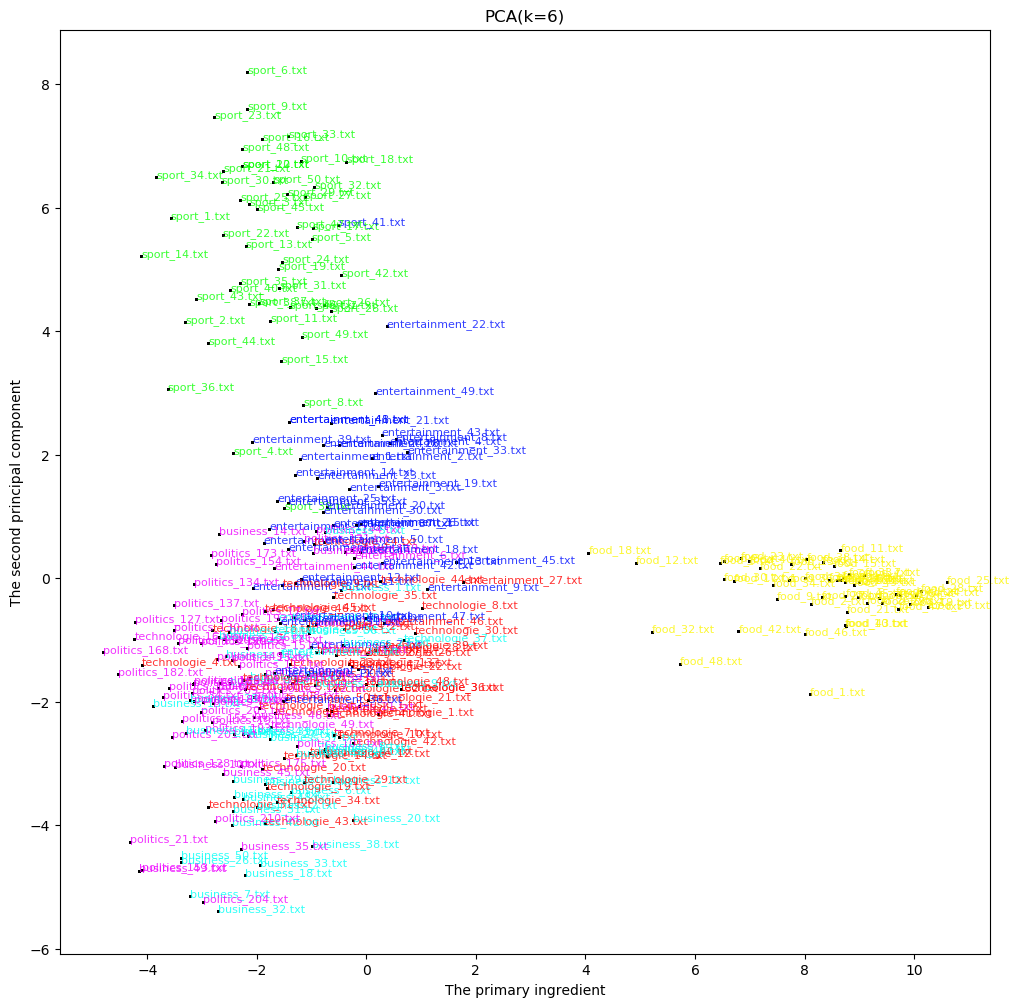

In [18]:
from sklearn.decomposition import PCA 

# 標準化
dfs = df.iloc[:, :].apply(lambda x: (x-x.mean())/x.std(), axis=0)
dfs.head()

# 主成分分析
pca = PCA(n_components=2)
pca.fit(dfs)

feature = pca.transform(dfs)

# プロットする
plt.figure(figsize=(12, 12))

cm = plt.get_cmap('hsv')
for x, y, name, cl in zip(feature[:, 0], feature[:, 1], pre_file, clusters):
    plt.text(x, y, name, alpha=0.8, size=8, color=cm(cl/num_clusters))
    plt.scatter(feature[:, 0], feature[:, 1], s=1, color="black")
    

plt.title("PCA(k=6)")
plt.xlabel("The primary ingredient")
plt.ylabel("The second principal component")
plt.show()

### クラスター分類

In [19]:
for i in range(num_clusters):
    print(i)
    for path_file, cls in zip(pre_file, clusters):
        if(cls == i):
            print(cls, path_file)

0
0 technologie_41.txt
0 technologie_40.txt
0 technologie_42.txt
0 technologie_43.txt
0 technologie_47.txt
0 technologie_46.txt
0 technologie_44.txt
0 technologie_50.txt
0 technologie_45.txt
0 technologie_3.txt
0 technologie_22.txt
0 technologie_36.txt
0 technologie_23.txt
0 technologie_2.txt
0 technologie_35.txt
0 technologie_21.txt
0 technologie_20.txt
0 technologie_34.txt
0 technologie_1.txt
0 technologie_5.txt
0 technologie_18.txt
0 technologie_30.txt
0 technologie_24.txt
0 technologie_31.txt
0 technologie_19.txt
0 technologie_4.txt
0 technologie_6.txt
0 technologie_27.txt
0 technologie_33.txt
0 technologie_32.txt
0 technologie_26.txt
0 technologie_7.txt
0 technologie_17.txt
0 entertainment_46.txt
0 technologie_9.txt
0 technologie_14.txt
0 technologie_28.txt
0 business_30.txt
0 technologie_29.txt
0 technologie_15.txt
0 technologie_8.txt
0 technologie_39.txt
0 technologie_10.txt
0 technologie_38.txt
0 music_1.txt
0 technologie_12.txt
0 technologie_13.txt
0 technologie_48.txt
0 enter

### Kの大きさを変えた場合

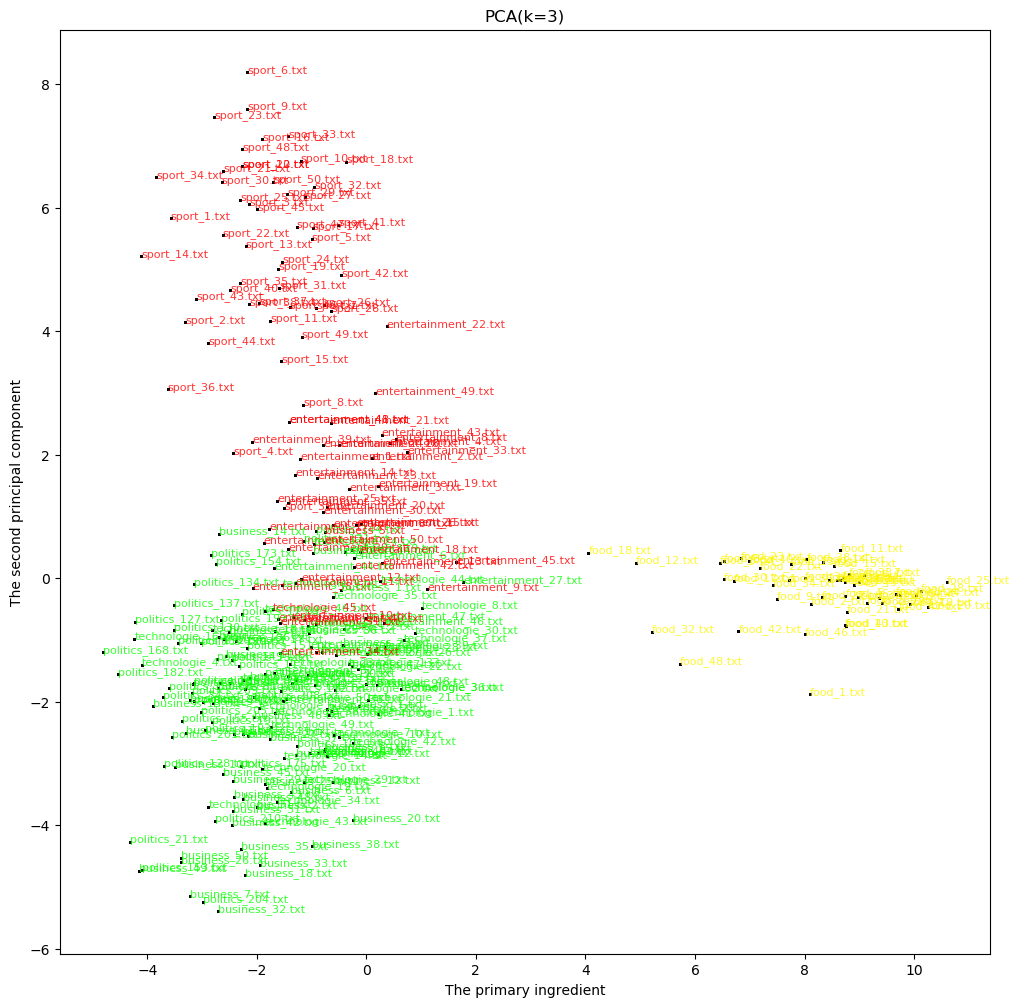

In [20]:
# 3
num_cluster = 3
km = KMeans(n_clusters=num_cluster, random_state = 0)
clusters = km.fit_predict(tf_idf)

# for i in range(num_cluster):
#     print(i)
#     for path_file, cls in zip(pre_file, clusters):
#         if(cls == i):
#             print(cls, path_file)
            
# 標準化
dfs = df.iloc[:, :].apply(lambda x: (x-x.mean())/x.std(), axis=0)
dfs.head()

# 主成分分析
pca = PCA(n_components=2)
pca.fit(dfs)

feature = pca.transform(dfs)

# プロットする
plt.figure(figsize=(12, 12))

cm = plt.get_cmap('hsv')
for x, y, name, cl in zip(feature[:, 0], feature[:, 1], pre_file, clusters):
    plt.text(x, y, name, alpha=0.8, size=8, color=cm(cl/num_clusters))
    plt.scatter(feature[:, 0], feature[:, 1], s=1, color="black")
    

plt.title("PCA(k=3)")
plt.xlabel("The primary ingredient")
plt.ylabel("The second principal component")
plt.show()

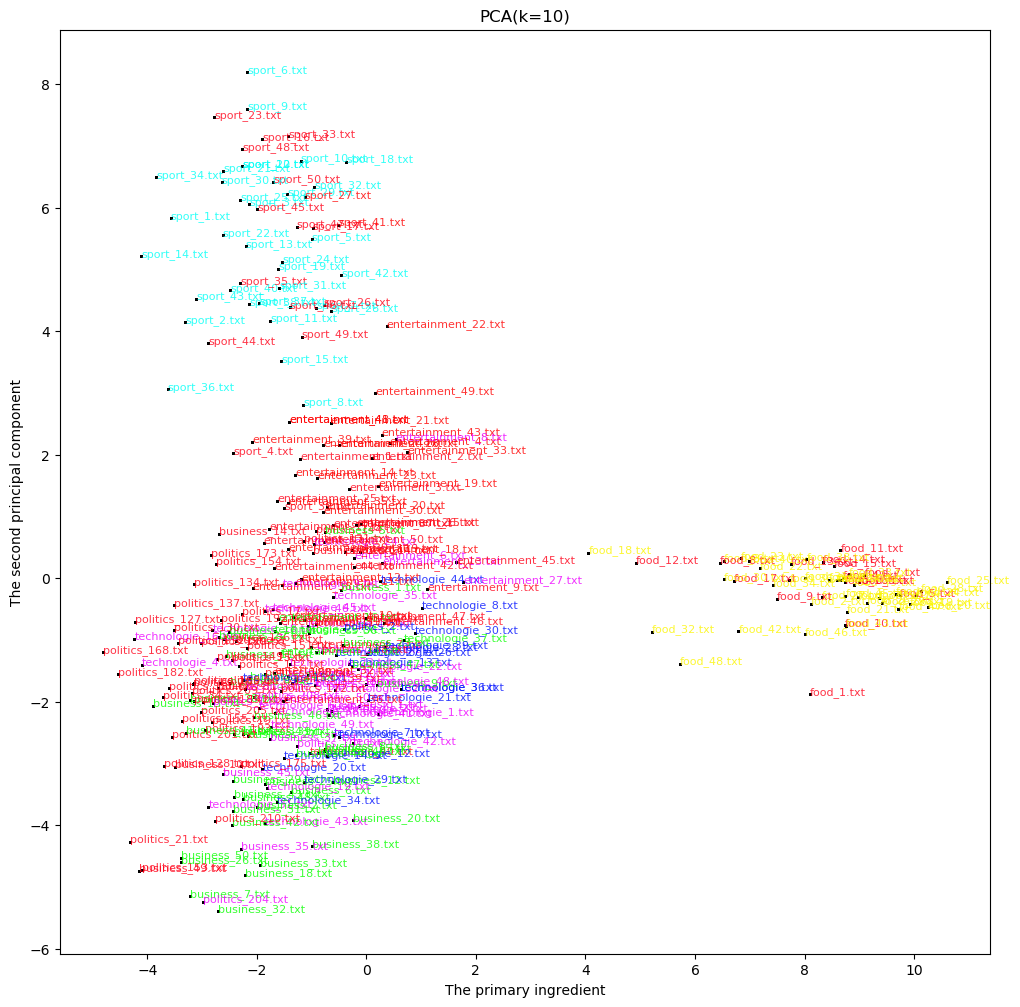

In [21]:
# 10
num_cluster = 10
km = KMeans(n_clusters=num_cluster, random_state = 0)
clusters = km.fit_predict(tf_idf)

# for i in range(num_cluster):
#     print(i)
#     for path_file, cls in zip(pre_file, clusters):
#         if(cls == i):
#             print(cls, path_file)
            
# 標準化
dfs = df.iloc[:, :].apply(lambda x: (x-x.mean())/x.std(), axis=0)
dfs.head()

# 主成分分析
pca = PCA(n_components=2)
pca.fit(dfs)

feature = pca.transform(dfs)

# プロットする
plt.figure(figsize=(12, 12))

cm = plt.get_cmap('hsv')
for x, y, name, cl in zip(feature[:, 0], feature[:, 1], pre_file, clusters):
    plt.text(x, y, name, alpha=0.8, size=8, color=cm(cl/num_clusters))
    plt.scatter(feature[:, 0], feature[:, 1], s=1, color="black")
    

plt.title("PCA(k=10)")
plt.xlabel("The primary ingredient")
plt.ylabel("The second principal component")
plt.show()